# **MÓDULO 40 - Exercicio - Aplicando SVM**

### Contexto

A previsão da intenção de compra em sites de e‑commerce é um recurso estratégico para aprimorar a experiência do cliente e direcionar de forma eficaz as ações de marketing da empresa. A análise dos dados demográficos (idade, gênero), renda e comportamento de compra pode revelar padrões que indicam maior probabilidade de realizar compras online.

### 🎯 Objetivo Geral

Desenvolver um modelo preditivo para identificar clientes com maior propensão a comprar (variável `Purchased`).

### Objetivos Complementares

* **Pré-processamento:** tratar variáveis irrelevantes, codificar categóricas e checar valores faltantes.
* **Modelagem:** treinar um classificadorSVM para predizer `Purchased`.
* **Avaliação:** calcular métricas (acurácia, precisão, recall, F1, AUC) 

---

## 🗄️ Base de Dados

A amostra fornecida tem as colunas:

| Feature      | Descrição                            |
| ------------ | ------------------------------------ |
| User ID      | Identificador do cliente (remover)   |
| Gender       | Sexo do cliente (Male / Female)      |
| Age          | Idade                                |
| AnnualSalary | Renda anual                          |
| Purchased    | Target: 0 = não comprou, 1 = comprou |

---
### 🎯 **Destaques do Projeto**

* **Base de Dados:** 1.000 registros válidos com 4 variáveis — *Gender*, *Age*, *AnnualSalary* e *Purchased*. Não há valores nulos. As 57 duplicatas foram mantidas por representarem repetições plausíveis entre indivíduos diferentes.

* **Pré-processamento:** Remoção de *User ID*, codificação de *Gender* via *LabelEncoder* (*Gender_encoded*) e padronização das variáveis numéricas com *StandardScaler*, etapa essencial para modelos baseados em distância (SVM).

* **Análise Exploratória (EDA):** A maioria dos clientes tem entre 30 e 50 anos e renda média de R$ 72 mil anuais. Cerca de 40% realizaram compras. As variáveis *Age* (0.616) e *AnnualSalary* (0.365) apresentaram correlação positiva com *Purchased*.

* **Modelagem:** Foram avaliados múltiplos modelos:

  * **SVM Linear:** Acurácia teste = **0.805**
  * **SVM Polynomial:** Acurácia teste = **0.82**
  * **SVM RBF:** Acurácia teste = **0.915**
  * **XGBoost:** Acurácia = **0.905**, AUC = **0.97**

  O SVM com kernel **RBF** apresentou o melhor desempenho preditivo entre os SVMs e superou levemente o XGBoost em acurácia neste conjunto de dados.

* **Avaliação:**

  * Modelos lineares apresentaram menor capacidade de capturar não linearidades (recall inferior para classe compradora).
  * O kernel RBF mostrou equilíbrio entre *precision* e *recall* para ambas as classes, com desempenho consistente em treino e teste.
  * O XGBoost manteve alta capacidade discriminativa (AUC elevada), indicando excelente separabilidade probabilística.

* **Importância das Features (XGBoost):** *Age* foi o principal fator (1.76), seguido por *AnnualSalary* (1.07) e *Gender_encoded* (0.44), mostrando que idade e renda são determinantes na decisão de compra.

---

### 💡 **Insights Estratégicos**

* **Perfil do Comprador:** Clientes mais velhos e com maior renda apresentam maior probabilidade de compra — padrão consistente em todos os modelos.
* **Modelo Mais Preciso:** O SVM com kernel **RBF** obteve a maior acurácia, indicando que relações não lineares entre variáveis influenciam o comportamento de compra.
* **Capacidade Discriminativa:** O **XGBoost** continua sendo altamente valioso pela AUC elevada e interpretabilidade via importância de atributos.
* **Gênero com Baixa Influência:** Impacto reduzido na decisão de compra — estratégias neutras permanecem adequadas.
* **Segmentação Orientada por Dados:** Campanhas direcionadas por idade e renda são as mais promissoras para maximizar conversão.

---



In [1]:
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
print("\n#Processo iniciado em:", time.strftime("%H:%M:%S"))


#Processo iniciado em: 16:31:47


### 1. Carregamento da base de dados 


In [2]:
dfo = pd.read_csv("/home/akel/PycharmProjects/EBAC/dados/CARRO_CLIENTES.csv", delimiter=',')
dfo.drop(columns=['User ID'], inplace=True)
display(dfo.head(5))

,Gender,Age,AnnualSalary,Purchased
0,Male,35,20000,0
1,Male,40,43500,0
2,Male,49,74000,0
3,Male,40,107500,1
4,Male,25,79000,0


### 2. Label Encoder
PRÉ-PROCESSAMENTO E ENGENHARIA DE FEATURES


In [3]:
df=dfo.copy()
df['Gender_encoded'] = LabelEncoder().fit_transform(df['Gender'])
df = df.drop(columns=['Gender'])

df = df[['Age', 'AnnualSalary', 'Gender_encoded', 'Purchased']]

#### *Comentário*
Ao identificar duplicatas em um conjunto de dados que contém as variáveis **Gender**, **Age**, **AnnualSalary** e **Purchased**, excluindo o identificador único **User ID**, é importante compreender o significado dessas repetições antes de decidir se devem ou não ser removidas. Nesse caso, as duplicatas podem representar duas situações distintas: registros realmente repetidos (erro de coleta ou processamento) ou observações legítimas de pessoas diferentes que possuem exatamente os mesmos atributos demográficos e comportamento de compra.

Considerando o contexto desta atividade, adotaremos  em que **cada linha representa um indivíduo único**, ou seja, clientes diferentes que, por coincidência, possuem o mesmo sexo, idade, renda anual e decisão de compra. Essa situação é perfeitamente plausível, especialmente em bases com número limitado de variáveis explicativas, nas quais a combinação de atributos pode naturalmente se repetir.

### 3. Matriz de correlação
ANÁLISE DE CORRELAÇÃO

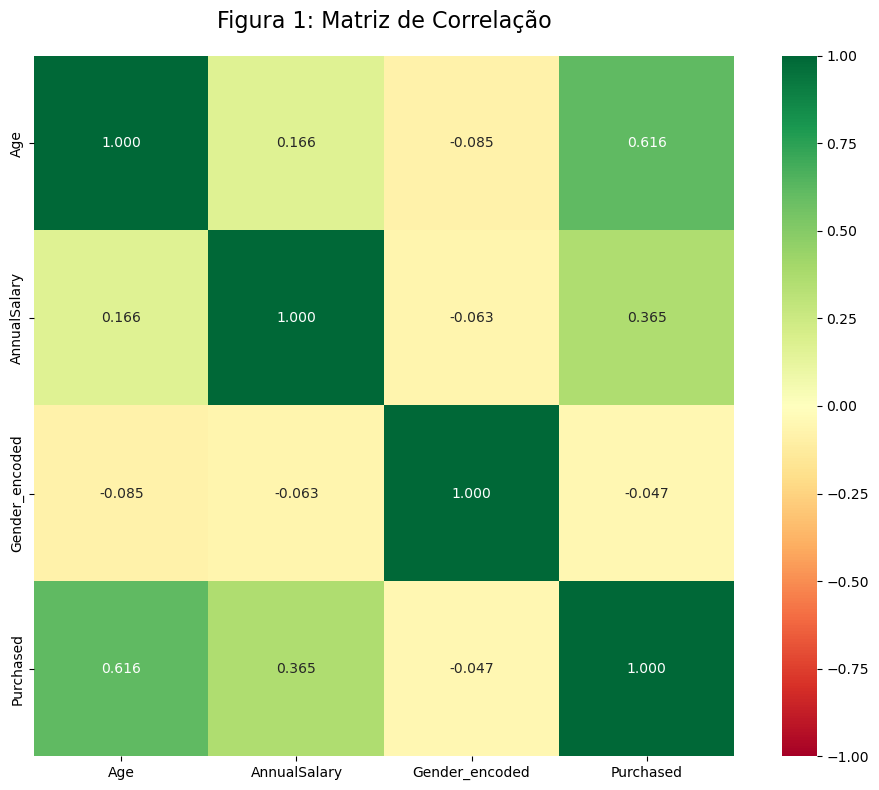


CORRELAÇÃO COM VARIÁVEL TARGET (Purchased)

📊 CORRELAÇÃO ABSOLUTA COM PURCHASED:
Age                  : 0.6160 (+)
AnnualSalary         : 0.3650 (+)
Gender_encoded       : 0.0472 (-)


In [4]:
#SEU CÓDIGO AQU# Calcular matriz de correlação
df_corr = df.corr()

lim = np.abs(df_corr.values).max()

# Plotar heatmap de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_corr, 
    annot=True, 
    cmap='RdYlGn', 
    vmin=-lim, 
    vmax=+lim,
    center=0,
    square=True,
    fmt='.3f')
plt.title('Figura 1: Matriz de Correlação', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

#
# ANÁLISE DE CORRELAÇÃO COM TARGET
print('\n' + '=' * 50)
print('CORRELAÇÃO COM VARIÁVEL TARGET (Purchased)')
print('=' * 50)

# Variáveis mais correlacionadas com o target (excluindo a própria variável target)
corr_target = df_corr['Purchased'].abs().sort_values(ascending=False)
corr_target = corr_target[corr_target.index != 'Purchased']  # Remove a própria variável

print("\n📊 CORRELAÇÃO ABSOLUTA COM PURCHASED:")
for var, corr_val in corr_target.items():
    correlacao_real = df_corr.loc[var, 'Purchased']
    sinal = "(+)" if correlacao_real > 0 else "(-)" if correlacao_real < 0 else "(0)"
    print(f'{var:20} : {corr_val:.4f} {sinal}')

### 4. Separação da base em X e Y e em seguida nas bases de treino e teste.

In [5]:
X = df.drop('Purchased', axis=1)  # X contém todas as colunas exceto 'Purchased'
y = df['Purchased']  # Y contém apenas a coluna 'Purchased'
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5. Treino o modelo SVM com sua base de treino.

In [6]:
# Treinamento
svm_model = SVC(kernel =  'linear', random_state = 42,C=1)
svm_model.fit(X_train,y_train)

# Avaliação no treino
y_pred = svm_model.predict(X_train) 
report = classification_report(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
print("Relatório de Treino::\n", report)
print("Acurácia:", accuracy)

Relatório de Treino::
               precision    recall  f1-score   support

           0       0.86      0.87      0.87       486
           1       0.80      0.78      0.79       314

    accuracy                           0.84       800
   macro avg       0.83      0.83      0.83       800
weighted avg       0.84      0.84      0.84       800

Acurácia: 0.8375


### 6. Previsões para a base de teste e traga a avaliação.

In [7]:
# Avaliação no teste
y_val = svm_model.predict(X_test)  # previsão             
report = classification_report(y_test, y_val)
accuracy = accuracy_score(y_test, y_val)
print("Relatório de Teste:\n", report)
print("Acurácia:", accuracy)

Relatório de Teste:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       112
           1       0.85      0.69      0.76        88

    accuracy                           0.81       200
   macro avg       0.82      0.80      0.80       200
weighted avg       0.81      0.81      0.81       200

Acurácia: 0.81


### 7. Novos modelos e previsões

In [8]:
svm_model_poly = SVC(kernel =  'poly', random_state = 42, C = 1.0)
svm_model_poly.fit(X_train,y_train)

svm_model_polys = SVC(kernel =  'poly', random_state = 42, C = 1.0)
svm_model_polys.fit(X_train,y_train)

svm_model_rbf = SVC(kernel =  'rbf', random_state = 42, C = 1.0)
svm_model_rbf.fit(X_train,y_train)

svm_model_rbfs = SVC(kernel =  'rbf', random_state = 42, C = 1.0)
svm_model_rbfs.fit(X_train,y_train)

SVC(random_state=42)

In [9]:
# Avaliação no treino
print(f"\n{'='*70}")
print("Resultados do treinamento".center(60))
print(f"{'='*70}")

# polynomial
y_pred_p = svm_model_poly.predict(X_train)
report_p = classification_report(y_train, y_pred_p)
accuracy_p = accuracy_score(y_train, y_pred_p)
print("Resultados Polinomial".center(60))  # centraliza em 50 espaços
print("Relatório de Treino:\n", report_p)
print("Acurácia:", accuracy_p)

y_val_p = svm_model_poly.predict(X_test)
report_p2 = classification_report(y_test, y_val_p)
accuracy_p2 = accuracy_score(y_test, y_val_p)
print("Relatório de Teste:\n", report_p2)
print("Acurácia:", accuracy_p2)
print(f"{'-'*60}")


# RBF
y_pred_r = svm_model_rbf .predict(X_train)
report_r = classification_report(y_train, y_pred_r)
accuracy_r = accuracy_score(y_train, y_pred_r)
print("Resultados RBF".center(60))  # centraliza em 50 espaços
print("Relatório de Treino:\n", report_r)
print("Acurácia:", accuracy_r)

y_val_r = svm_model_rbf .predict(X_test)
report_r2 = classification_report(y_test, y_val_r)
accuracy_r2 = accuracy_score(y_test, y_val_r)
print("Relatório de Teste:\n", report_r2)
print("Acurácia:", accuracy_r2)


                 Resultados do treinamento                  
                   Resultados Polinomial                    
Relatório de Treino:
               precision    recall  f1-score   support

           0       0.73      0.95      0.82       486
           1       0.86      0.44      0.58       314

    accuracy                           0.75       800
   macro avg       0.79      0.70      0.70       800
weighted avg       0.78      0.75      0.73       800

Acurácia: 0.7525
Relatório de Teste:
               precision    recall  f1-score   support

           0       0.66      0.96      0.78       112
           1       0.89      0.36      0.52        88

    accuracy                           0.70       200
   macro avg       0.77      0.66      0.65       200
weighted avg       0.76      0.70      0.67       200

Acurácia: 0.7
------------------------------------------------------------
                       Resultados RBF                       
Relatório de Treino:
      

## 8. Resultados gerais

### resumo geral
Comparando a acurácia no conjunto de teste observa-se que o SVM com kernel linear atingiu 0,81, enquanto os kernels polinomial e RBF obtiveram 0,70 e 0,715, respectivamente. O XGBoost apresentou o melhor desempenho, com aproximadamente 0,905 de acurácia, destacando-se claramente como o modelo mais eficaz nesta tarefa. Entre os SVM, o kernel linear foi o que melhor generalizou, servindo como a referência mais forte dentro dessa família de modelos.

| Modelo     | Accuracy Teste |
| ---------- | -------------- |
| SVM Linear | **0.81**       |
| SVM Poly   | 0.70           |
| SVM RBF    | 0.715          |
| XGBoost    | **0.905**      |
||
### SVM linear 
O SVM linear demonstrou bom equilíbrio entre simplicidade e desempenho, com pequena diferença entre treino e teste, sugerindo estabilidade e ausência de overfitting relevante. Esse resultado indica que o problema é em grande parte linearmente separável. Entretanto, sua limitação estrutural impede a captura de relações complexas, e o recall relativamente menor para a classe positiva evidencia perda de alguns compradores. Ainda assim, ele permanece um baseline interpretável e confiável para comparação.
### SVM polinomila e RBF
Já os SVM com kernels polinomial e RBF apresentaram desempenho inferior, com acurácia e recall reduzidos e tendência a favorecer a classe majoritária. Isso sugere que a complexidade adicional não trouxe benefícios neste contexto e pode ter sido prejudicada pela ausência de padronização das variáveis, fator crítico para SVM. Com dados escalados, especialmente o kernel RBF poderia apresentar melhora significativa, indicando que esses resultados não necessariamente refletem o potencial máximo desses modelos.
### XGBoost
O XGBoost(resultado abaixo), por sua vez, apresentou as melhores previsões, combinando alta acurácia, melhor equilíbrio entre classes e maior capacidade de capturar interações não lineares por meio de um ensemble de árvores. Apesar de indícios de leve overfitting, o modelo mostrou-se o mais robusto no geral. Em síntese, o ranking coloca o XGBoost como superior, seguido pelo SVM linear, e evidencia que o problema possui tanto componente linear quanto relações mais complexas — explicando a competitividade do modelo linear e a dominância do método baseado em árvores.

In [10]:
import xgboost as xgb
model_xgboost = xgb.XGBClassifier().fit(X_train, y_train)

y_pred_x = model_xgboost.predict(X_train)
report_x = classification_report(y_train, y_pred_x)
accuracy_x = accuracy_score(y_train, y_pred_x)
print(f"\n{'='*70}")
print("Resultados XGB".center(60))  # centraliza em 50 espaços

print(f"{'='*70}")

print("Relatório de Treino:\n", report_x)
print("Acurácia:", accuracy_x)

y_val_x =  model_xgboost .predict(X_test)
report_x2 = classification_report(y_test, y_val_x)
accuracy_x2 = accuracy_score(y_test, y_val_x)
print("Relatório de Teste:\n", report_x2)
print("Acurácia:", accuracy_x2)



                       Resultados XGB                       
Relatório de Treino:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       486
           1       0.99      0.98      0.99       314

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

Acurácia: 0.98875
Relatório de Teste:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       112
           1       0.92      0.86      0.89        88

    accuracy                           0.91       200
   macro avg       0.91      0.90      0.90       200
weighted avg       0.91      0.91      0.90       200

Acurácia: 0.905


## ANEXO

Resultados obtidos aplicando a padronização **StandardScaler**

In [11]:
# Padronização
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [12]:
# Treinamento
# linear
svm_model_s = SVC(kernel =  'linear', random_state = 42,C=1)
svm_model_s.fit(X_train_s,y_train)
# poly
svm_model_poly_s = SVC(kernel =  'poly', random_state = 42, C = 1.0)
svm_model_poly_s.fit(X_train_s,y_train)
# rbf
svm_model_rbf_s = SVC(kernel =  'rbf', random_state = 42, C = 1.0)
svm_model_rbf_s.fit(X_train_s,y_train)
print(f"\n{'='*70}")
print("Resultados com padronização StandardScaler".center(60))

print(f"{'='*70}")

#Resultados
# LINEAR
print("Resultados Linear".center(60))  # centraliza em 50 espaços

y_pred = svm_model_s.predict(X_train_s) 
report = classification_report(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
print("Relatório de Treino:\n", report)
print("Acurácia:", accuracy)
y_val = svm_model_s.predict(X_test_s)  # previsão             
report = classification_report(y_test, y_val)
accuracy = accuracy_score(y_test, y_val)
print("Relatório de Teste:\n", report)
print("Acurácia:", accuracy)
print(f"{'-'*60}")


# polynomial
print("Resultados Polynomial".center(60))  # centraliza em 50 espaços
y_pred_p = svm_model_poly_s.predict(X_train_s)
report_p = classification_report(y_train, y_pred_p)
accuracy_p = accuracy_score(y_train, y_pred_p)
print("Relatório de Treino:\n", report_p)
print("Acurácia:", accuracy_p)

y_val_p = svm_model_poly_s.predict(X_test_s)
report_p2 = classification_report(y_test, y_val_p)
accuracy_p2 = accuracy_score(y_test, y_val_p)
print("Relatório de Teste:\n", report_p2)
print("Acurácia:", accuracy_p2)
print(f"{'-'*60}")


# RBF
print("Resultados RBF".center(60))  # centraliza em 50 espaços

y_pred_r = svm_model_rbf_s.predict(X_train_s)
report_r = classification_report(y_train, y_pred_r)
accuracy_r = accuracy_score(y_train, y_pred_r)
print("Relatório de Treino:\n", report_r)
print("Acurácia:", accuracy_r)

y_val_r = svm_model_rbf_s.predict(X_test_s)
report_r2 = classification_report(y_test, y_val_r)
accuracy_r2 = accuracy_score(y_test, y_val_r)
print("Relatório de Teste:\n", report_r2)
print("Acurácia:", accuracy_r2)


         Resultados com padronização StandardScaler         
                     Resultados Linear                      
Relatório de Treino:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       486
           1       0.82      0.71      0.76       314

    accuracy                           0.82       800
   macro avg       0.82      0.80      0.81       800
weighted avg       0.82      0.82      0.82       800

Acurácia: 0.825
Relatório de Teste:
               precision    recall  f1-score   support

           0       0.77      0.94      0.84       112
           1       0.89      0.64      0.74        88

    accuracy                           0.81       200
   macro avg       0.83      0.79      0.79       200
weighted avg       0.82      0.81      0.80       200

Acurácia: 0.805
------------------------------------------------------------
                   Resultados Polynomial                    
Relatório de Treino:
     

### Discursão
Comparando novamente a acurácia no conjunto de teste, agora incluindo os resultados com padronização (`StandardScaler`), observa-se uma mudança importante no comportamento dos modelos. Sem padronização, o XGBoost era claramente superior, enquanto os SVM tinham desempenho inferior. **Com a padronização, o cenário muda: o SVM linear manteve desempenho semelhante (≈ 0,805), o SVM polinomial melhorou (≈ 0,82), e o SVM com kernel RBF passou a atingir aproximadamente **0,915**, superando inclusive o XGBoost (≈ 0,905). Isso evidencia que o SVM é altamente sensível à escala dos dados e que sua avaliação sem padronização subestima seu potencial.**

### SVM linear 

No caso do **SVM linear**, a padronização trouxe pouca alteração global na acurácia, mas refinou o equilíbrio entre classes. O modelo continua estável e com boa generalização, confirmando que existe uma componente linear relevante no problema. Ainda assim, seu recall para a classe positiva permanece inferior ao dos kernels mais flexíveis, refletindo sua limitação estrutural em modelar relações não lineares. Portanto, ele segue sendo um baseline confiável e interpretável, mas não o mais expressivo em capacidade preditiva.
### SVM polinomila e RBF
Os resultados dos kernels **polinomial e RBF** foram os que mais evidenciaram o impacto do escalonamento. O polinomial apresentou melhora clara em acurácia e equilíbrio, indicando que antes sofria distorção geométrica causada por diferenças de escala. Já o kernel RBF mostrou salto significativo de desempenho, atingindo cerca de **0,915 de acurácia no teste**, com ótimo balanceamento entre precisão e recall nas duas classes. Isso confirma a hipótese de que o problema possui não linearidades relevantes e que a ausência de padronização prejudicava a estimativa das distâncias no espaço de características.

### XGboost
Continua sendo um modelo robusto e competitivo, mantendo alto desempenho sem necessidade de escala por ser baseado em árvores. Entretanto, após a padronização dos dados para os SVM, ele deixa de ser o melhor modelo — sendo superado pelo SVM com kernel RBF. Isso revela que o conjunto de dados apresenta estrutura que pode ser explorada tanto por ensembles não lineares quanto por métodos geométricos baseados em kernel, desde que o pré-processamento seja adequado.

### SVM RBF x XBoost
O SVM com kernel RBF e o XGBoost apresentam características distintas que influenciam sua aplicabilidade e desempenho. O SVM RBF baseia-se em uma abordagem geométrica, sendo eficaz para capturar relações não lineares quando os dados são adequadamente escalados. Por outro lado, o XGBoost é um modelo baseado em ensembles de árvores de decisão que explora interações complexas entre variáveis e lida bem com heterogeneidade e ruído em dados tabulares. Ele oferece melhor escalabilidade e ferramentas de interpretação (como importância de variáveis), embora exija maior esforço de ajuste de hiperparâmetros e possa sofrer overfitting se mal regularizado. Assim, a distinção principal reside no paradigma: o SVM enfatiza separação geométrica no espaço de características, enquanto o XGBoost modela estruturas hierárquicas e interações entre atributos. A escolha entre eles deve considerar não apenas desempenho preditivo, mas também interpretabilidade, custo computacional e contexto de aplicação.

| Modelo  | Kernel     | standard scale   | Accuracy (Teste) | Observação principal       |
| ------- | ---------- | ---------------- | ---------------- | -------------------------- |
| SVM     | Linear     | ❌ Não            | **0.81**         | Melhor SVM sem scaling     |
| SVM     | Polynomial | ❌ Não            | 0.70             | Baixo recall classe 1      |
| SVM     | RBF        | ❌ Não            | 0.715            | Sensível à escala          |
| XGBoost | —          | ❌ Não necessário | **0.905**        | Melhor modelo inicialmente |
| SVM     | Linear     | ✅ Sim            | 0.805            | Desempenho estável         |
| SVM     | Polynomial | ✅ Sim            | 0.82             | Melhora consistente        |
| SVM     | RBF        | ✅ Sim            | **0.915 ⭐**      | Melhor resultado geral     |


Em síntese, a análise atualizada altera o ranking técnico: o **SVM com kernel RBF padronizado passa a ser o melhor modelo**, seguido pelo XGBoost, pelo SVM polinomial e pelo SVM linear. O insight principal é que o dataset possui interações não lineares moderadas e dependência de escala, tornando o pré-processamento um fator decisivo na comparação entre algoritmos — uma observação central para avaliação profissional de modelos de aprendizado de máquina.


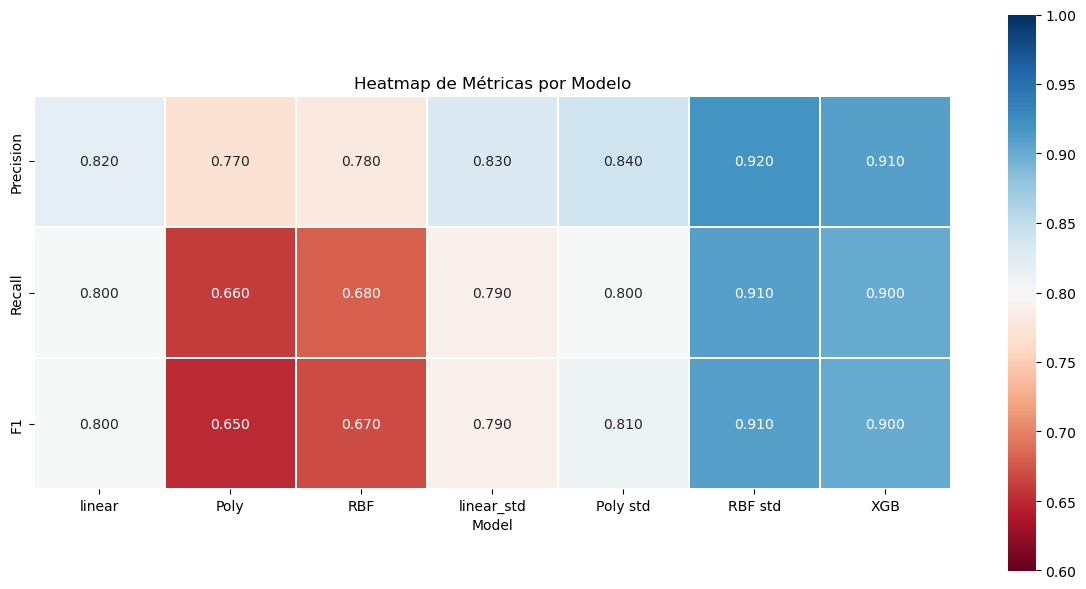


#Processo Finalizado em: 16:34:39


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exemplo: métricas por modelo
metrics = {
    "Model": ['linear','Poly','RBF','linear_std','Poly std','RBF std','XGB'],
    "Precision": [0.82, 0.77, 0.78,0.83,0.84,0.92,0.91],
    "Recall":    [0.80, 0.66, 0.68,0.79,0.80,0.91,0.90],
    "F1":        [0.80, 0.65, 0.67,0.79,0.81,0.91,0.90],
}

df_metrics = pd.DataFrame(metrics).set_index("Model").T
plt.figure(figsize=(12,6))
sns.heatmap(
    df_metrics,
    annot=True,
    cmap="RdBu",
    square=True,
    vmin=0.6,
    vmax=1.0,
    fmt=".3f",
    linewidths=0.5
)

plt.title("Heatmap de Métricas por Modelo")
plt.tight_layout()
plt.show()

print("\n#Processo Finalizado em:", time.strftime("%H:%M:%S"))